In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import torch
import torch.nn as nn
from torch import optim

import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Train/TRAIN_.csv',header=0,index_col=None).iloc[:,1:]
test=pd.read_csv('/content/drive/MyDrive/Train/TEST_.csv',header=0,index_col=None).iloc[:,1:]
valid=pd.read_csv('/content/drive/MyDrive/Train/VAL_.csv',header=0,index_col=None).iloc[:,1:]

In [ ]:
if torch.cuda.is_available(): 
    print('El dispositivo que se usará a partir de ahora es ' + torch.cuda.get_device_name(0))
    device = torch.device("cuda:0")
else:
    print('Tu equipo no cuenta con un dispositivo compatible con CUDA')
    device = torch.device("cpu")

El dispositivo que se usará a partir de ahora es Tesla T4


In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
torch.cuda.current_device()

0

In [ ]:
torch.backends.cudnn.enables = False

In [ ]:
seed = 10
torch.manual_seed(seed)

In [ ]:
train.shape, valid.shape, test.shape

((396408, 24), (158563, 24), (105709, 24))

In [ ]:
df_train_np = np.stack([train[col].values for col in train], 1)
df_train_tensor = torch.tensor(df_train_np, dtype=torch.float)
df_train_tensor[0]

tensor([0.5365, 0.4831, 0.5028, 0.5017, 0.5550, 0.4956, 0.3937, 0.4715, 0.4859,
        0.4867, 0.4588, 0.4819, 0.4761, 0.5949, 0.5108, 0.5747, 0.5116, 0.4501,
        0.5572, 0.5252, 0.4692, 0.4934, 0.5095, 0.5421])

In [ ]:
outputs_train_tensor = df_train_tensor

In [ ]:
df_valid_np = np.stack([valid[col].values for col in valid], 1)
df_valid_tensor = torch.tensor(df_valid_np, dtype=torch.float)
df_valid_tensor[0]

tensor([0.4978, 0.4407, 0.3947, 0.4975, 0.4825, 0.4603, 0.4598, 0.3547, 0.5107,
        0.4583, 0.4971, 0.5065, 0.5015, 0.5493, 0.3980, 0.4780, 0.5112, 0.5351,
        0.4524, 0.4575, 0.3774, 0.5181, 0.4494, 0.3912])

In [ ]:
outputs_valid_tensor = df_valid_tensor

In [ ]:
train_data = TensorDataset(df_train_tensor, outputs_train_tensor)
valid_data = TensorDataset(df_valid_tensor, outputs_valid_tensor)

In [ ]:
batch_size = 1024
train_loader = DataLoader(train_data, batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size, shuffle=False)

In [ ]:
col = 24

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(col, int(col/2))
        self.fc2 = nn.Linear(int(col/2), int(col/4))
        self.fc3 = nn.Linear(int(col/4), int(col/2))
        self.fc4 = nn.Linear(int(col/2), col)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        x = self.fc4(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Classifier()
torch.cuda.current_device()

0

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) #betas #eps #weight_decay #amsgrad
model.to(device);

n_epochs = 100
valid_loss_min = np.Inf # track change in validation loss
train_losses, test_losses, accuracy_losses = [], [], []
start = time.process_time()
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, images)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)   
    train_losses.append(train_loss)
    test_losses.append(valid_loss)
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.10f} \tValidation Loss: {:.10f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.10f} --> {:.10f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'data_b16_lr0001.pt')
        valid_loss_min = valid_loss
        
print(time.process_time() - start)

Epoch: 1 	Training Loss: 0.0437332176 	Validation Loss: 0.0098850234
Validation loss decreased (inf --> 0.0098850234).  Saving model ...
Epoch: 2 	Training Loss: 0.0087864616 	Validation Loss: 0.0079650702
Validation loss decreased (0.0098850234 --> 0.0079650702).  Saving model ...
Epoch: 3 	Training Loss: 0.0065274260 	Validation Loss: 0.0062650679
Validation loss decreased (0.0079650702 --> 0.0062650679).  Saving model ...
Epoch: 4 	Training Loss: 0.0054802506 	Validation Loss: 0.0056405159
Validation loss decreased (0.0062650679 --> 0.0056405159).  Saving model ...
Epoch: 5 	Training Loss: 0.0049452268 	Validation Loss: 0.0051913682
Validation loss decreased (0.0056405159 --> 0.0051913682).  Saving model ...
Epoch: 6 	Training Loss: 0.0045639287 	Validation Loss: 0.0048969848
Validation loss decreased (0.0051913682 --> 0.0048969848).  Saving model ...
Epoch: 7 	Training Loss: 0.0043103331 	Validation Loss: 0.0047015298
Validation loss decreased (0.0048969848 --> 0.0047015298).  Savi

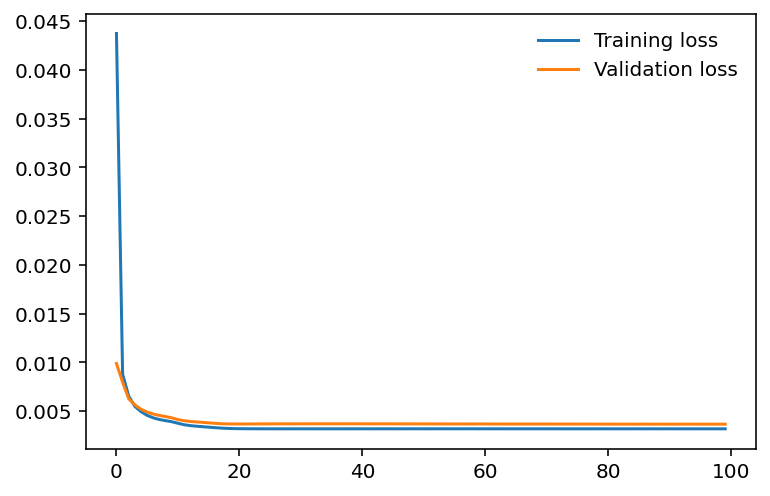

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
dfrb = pd.read_csv('/content/drive/MyDrive/Train/RB_.csv').iloc[:,1:]
dfub = pd.read_csv('/content/drive/MyDrive/Train/UB_.csv').iloc[:,1:]
dfcdb = pd.read_csv('/content/drive/MyDrive/Train/CDB_.csv').iloc[:,1:]

In [ ]:
test = pd.concat([test.iloc[:5000], dfrb.iloc[:5000], dfub.iloc[:5000], dfcdb.iloc[:5000]])

In [ ]:
target = []
for i in range(0, 5000):
  target.append(1)

for i in range(0, 5000):
  target.append(2)

for i in range(0, 5000):
  target.append(3)

for i in range(0, 5000):
  target.append(4)

In [ ]:
df_test_np = np.stack([test[col].values for col in test], 1)
df_test_tensor = torch.tensor(df_test_np, dtype=torch.float)
df_test_tensor[0]

tensor([0.4765, 0.5266, 0.4430, 0.3572, 0.4877, 0.4872, 0.5857, 0.4085, 0.3902,
        0.5402, 0.4742, 0.3978, 0.4600, 0.5869, 0.5503, 0.3575, 0.4732, 0.5156,
        0.3365, 0.4975, 0.4587, 0.3859, 0.4763, 0.4223])

In [ ]:
model.eval()

Classifier(
  (fc1): Linear(in_features=24, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=6, bias=True)
  (fc3): Linear(in_features=6, out_features=12, bias=True)
  (fc4): Linear(in_features=12, out_features=24, bias=True)
)

In [ ]:
w=df_test_tensor
w=w.cuda()
log_ps = model(w)
log_ps

tensor([[0.5248, 0.5046, 0.4756,  ..., 0.3658, 0.4931, 0.3799],
        [0.5268, 0.4085, 0.3845,  ..., 0.5607, 0.4673, 0.4742],
        [0.4535, 0.4293, 0.4630,  ..., 0.3594, 0.5280, 0.3688],
        ...,
        [0.5422, 0.4521, 0.4352,  ..., 0.4798, 0.4941, 0.4543],
        [0.5268, 0.4644, 0.4391,  ..., 0.4750, 0.5562, 0.4788],
        [0.4843, 0.4277, 0.4414,  ..., 0.5342, 0.5212, 0.4909]],
       device='cuda:0', grad_fn=<AddmmBackward>)

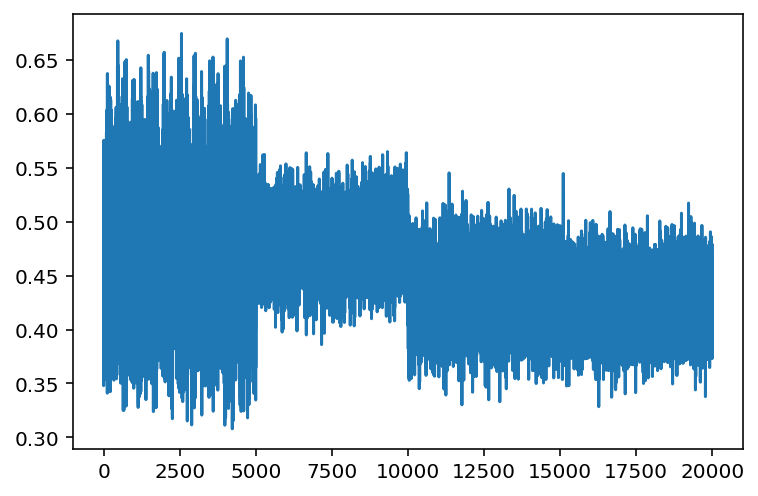

In [ ]:
plt.plot(log_ps.cpu().data.numpy()[:,8])

In [ ]:
error=abs(abs(test.values)-abs(log_ps.cpu().data.numpy()))
error

array([[0.04835754, 0.02200175, 0.0325597 , ..., 0.02009115, 0.01680242,
        0.04235996],
       [0.05724346, 0.06268313, 0.0310416 , ..., 0.03353884, 0.05045726,
        0.0504554 ],
       [0.02915397, 0.04622559, 0.01242081, ..., 0.09259385, 0.0279789 ,
        0.01210238],
       ...,
       [0.02752013, 0.01589063, 0.02127301, ..., 0.05535132, 0.0377356 ,
        0.26525389],
       [0.01120378, 0.01983365, 0.00456464, ..., 0.04174005, 0.02792943,
        0.35632376],
       [0.01295815, 0.03060004, 0.06529862, ..., 0.0439037 , 0.00513301,
        0.18239916]])

In [ ]:
def metric_mse(X1,X2):
    X=abs(X1-X2)
    vector=[]
    for i in X:
        k=0
        c=0
        for j in range(X.shape[1]):
            k+=i[j]**2
        k=np.sqrt(k/X.shape[1])
        vector.append(k)
        c+=1
    
    return np.array(vector)

In [ ]:
abs(test.values)[0]-abs(log_ps.cpu().data.numpy())[0]

array([-0.04835754,  0.02200175, -0.0325597 , -0.05538457, -0.00809766,
        0.0054309 ,  0.03790463, -0.04763492, -0.00572588,  0.03714732,
        0.03252515, -0.07281236,  0.0054829 ,  0.06906233,  0.0861863 ,
       -0.05765875, -0.01607341,  0.04073271,  0.01235857,  0.02114918,
        0.0272149 ,  0.02009115, -0.01680242,  0.04235996])

In [ ]:
error1=pd.DataFrame(metric_mse(abs(test.values),abs(log_ps.cpu().data.numpy())), columns=['error'])
error1

,error
0,0.040730
1,0.055490
2,0.046115
3,0.034793
4,0.044741
...,...
19995,0.084722
19996,0.081500
19997,0.107606
19998,0.098483


In [ ]:
error1['target']=target
error1

,error,target
0,0.040730,1
1,0.055490,1
2,0.046115,1
3,0.034793,1
4,0.044741,1
...,...,...
19995,0.084722,4
19996,0.081500,4
19997,0.107606,4
19998,0.098483,4


In [ ]:
result=error1

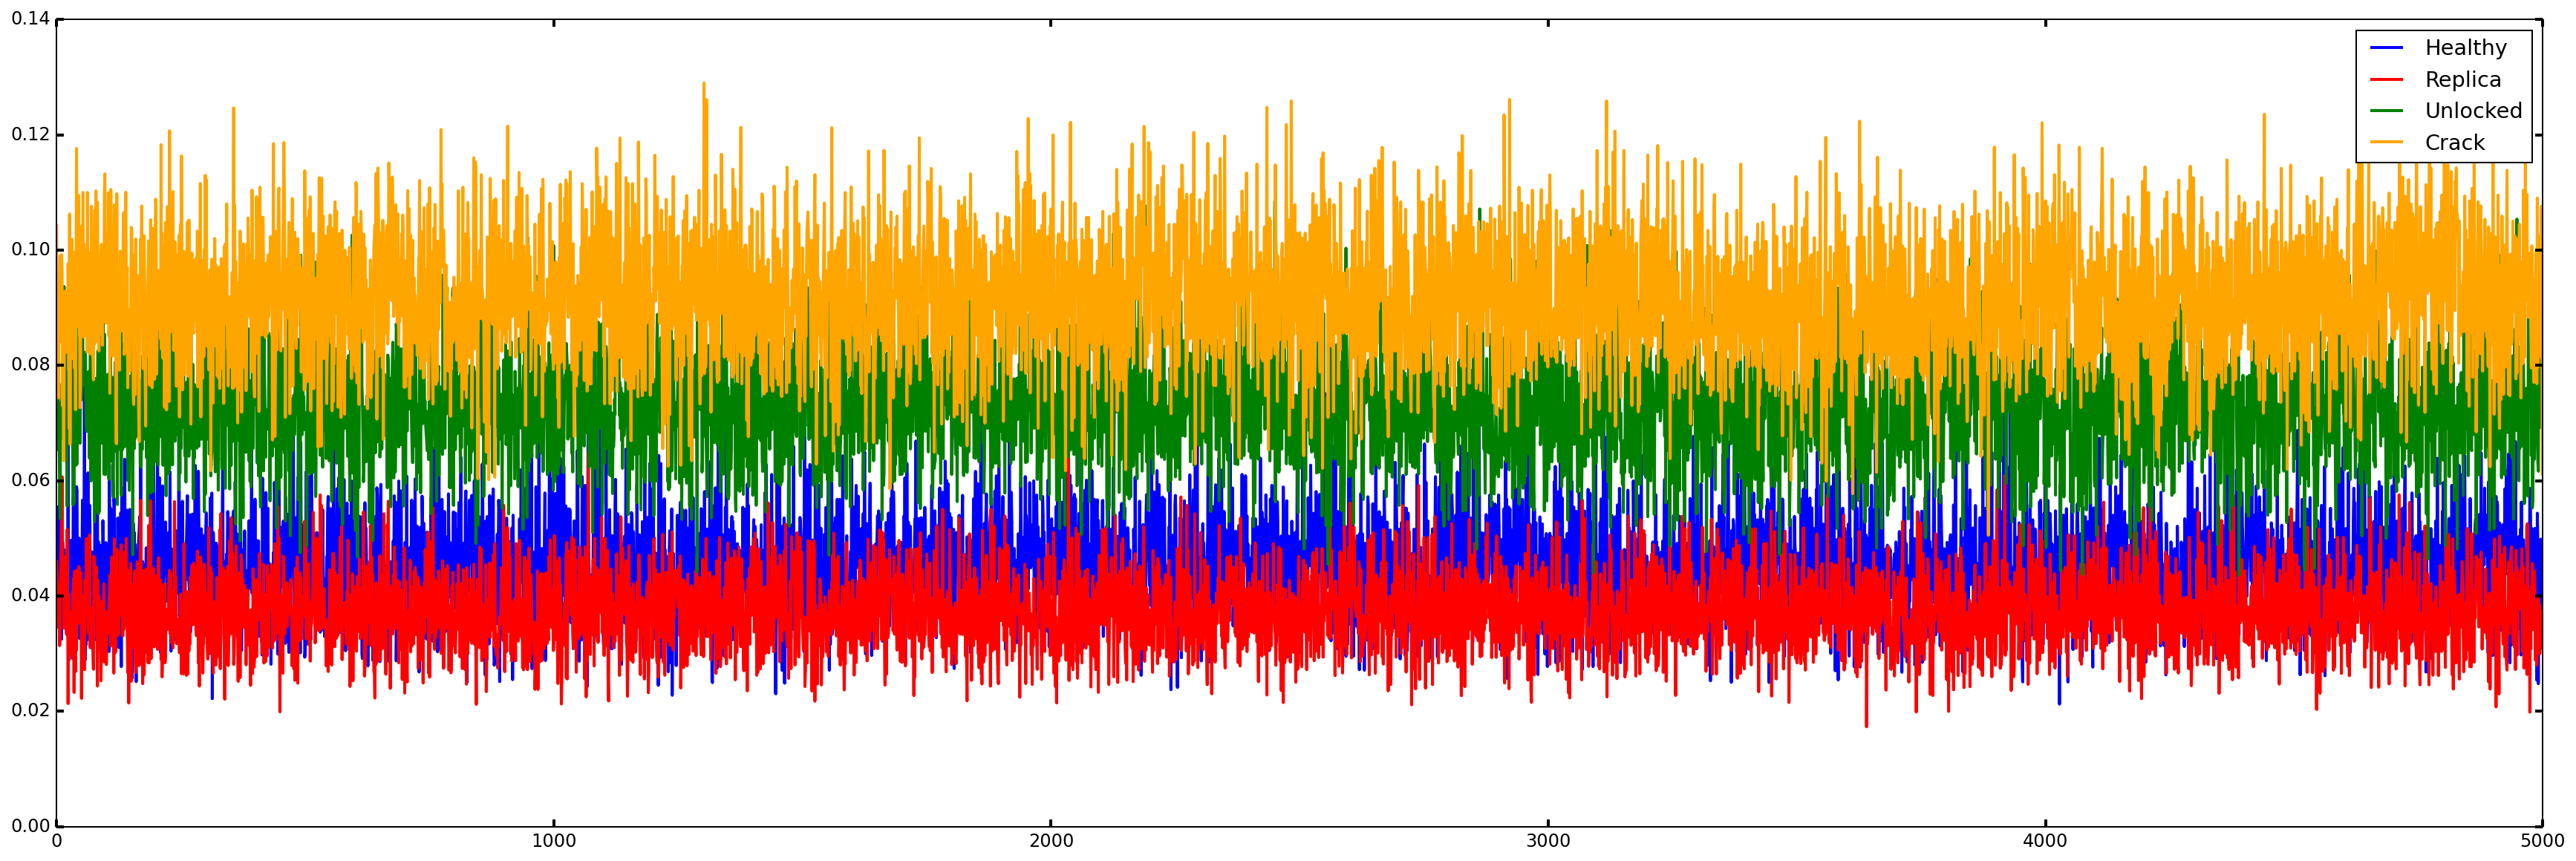

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.style.use('classic')


plt.plot(result[result.target==1.0]['error'].values, color="blue", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Healthy')
plt.plot(result[result.target==2.0]['error'].values, color="red", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Replica')
plt.plot(result[result.target==3.0]['error'].values, color="green", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Unlocked')
plt.plot(result[result.target==4]['error'].values, color="orange", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Crack')

plt.tick_params(which='both', width=2, length=5)
#plt.gcf().autofmt_xdate()
#plt.tight_layout()
plt.legend(frameon=True)
plt.savefig("wt2_temp.pdf",bbox_inches='tight')

In [ ]:
w1=np.concatenate((df_train_tensor,df_valid_tensor),axis=0)
w1 = torch.tensor(w1, dtype=torch.float)
w1=w1.cuda()
log_ps1 = model(w1)
log_ps1

tensor([[0.5460, 0.4811, 0.4696,  ..., 0.5369, 0.5350, 0.5013],
        [0.4612, 0.4623, 0.4695,  ..., 0.4444, 0.5298, 0.4431],
        [0.5033, 0.4761, 0.4588,  ..., 0.5478, 0.5360, 0.5096],
        ...,
        [0.5290, 0.4903, 0.5110,  ..., 0.5546, 0.5384, 0.5018],
        [0.4514, 0.5096, 0.5051,  ..., 0.4011, 0.4215, 0.3880],
        [0.5602, 0.5006, 0.4732,  ..., 0.6503, 0.5049, 0.5712]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
ws=600
error_train=metric_mse(abs(np.concatenate((train.values,valid.values),axis=0)),abs(log_ps1.cpu().data.numpy()))
error_train=pd.Series(error_train).rolling(ws).mean()[ws-1:].values
mean=np.mean(error_train)
std=np.std(error_train)

In [ ]:
np.max(error_train)

0.0908262776110491

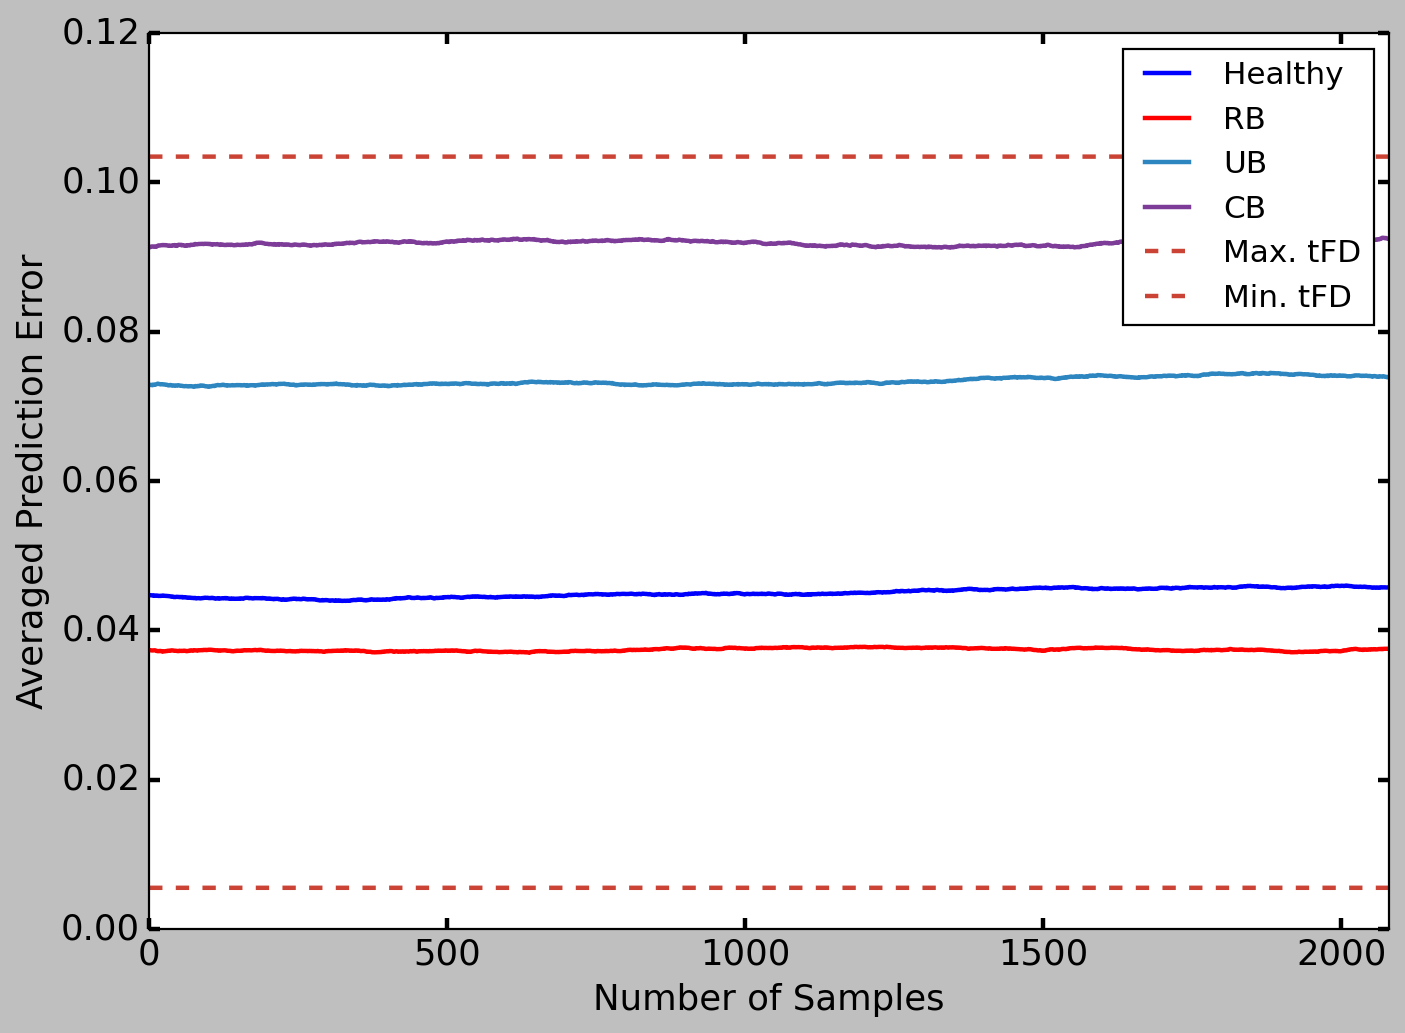

In [ ]:
plt.figure(figsize=(10,7))
plt.style.use('classic')
plt.rcParams['font.size'] = '16'
#plt.plot(diferencia, label='diferencia')
#plt.plot(datatest1["target"], label='target')
p=len(result[result.target==1]['error'].rolling(ws).mean()[ws-1:].values)

#plt.plot(error_train, color="lime", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Train')


plt.plot(result[result.target==1]['error'].rolling(ws).mean()[ws-1:].values, color="blue", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Healthy')
plt.plot(result[result.target==2]['error'].rolling(ws).mean()[ws-1:].values, color="red", marker=".", markersize=1, linestyle='solid',linewidth=2,label='RB')
plt.plot(result[result.target==3]['error'].rolling(ws).mean()[ws-1:].values, color=[i/255 for i in (46, 134, 193)], marker=".", markersize=1, linestyle='solid',linewidth=2,label='UB')
plt.plot(result[result.target==4]['error'].rolling(ws).mean()[ws-1:].values, color=[i/255 for i in (125, 60, 152 )], marker=".", markersize=1, linestyle='solid',linewidth=2,label='CB')

plt.xlabel('Number of Samples', fontsize=16)
plt.ylabel('Averaged Prediction Error', fontsize=16)
plt.plot([mean+3*std]*p, color=[i/255 for i in (203, 67, 53 )], linestyle='--',linewidth=2,label='Max. tFD')
plt.plot([mean-3*std]*p, color=[i/255 for i in (203, 67, 53 )], linestyle='--',linewidth=2,label='Min. tFD')
#plt.plot([np.max(error_train)]*p, color="skyblue", linestyle='--',linewidth=2,label='Lower threshold')
plt.xlim(right=2080)
plt.tick_params(which='both', width=2, length=5)
#plt.gcf().autofmt_xdate()
#plt.tight_layout()
plt.legend(frameon=True,fontsize=14)
plt.savefig("J3RESULTS.pdf",bbox_inches='tight')

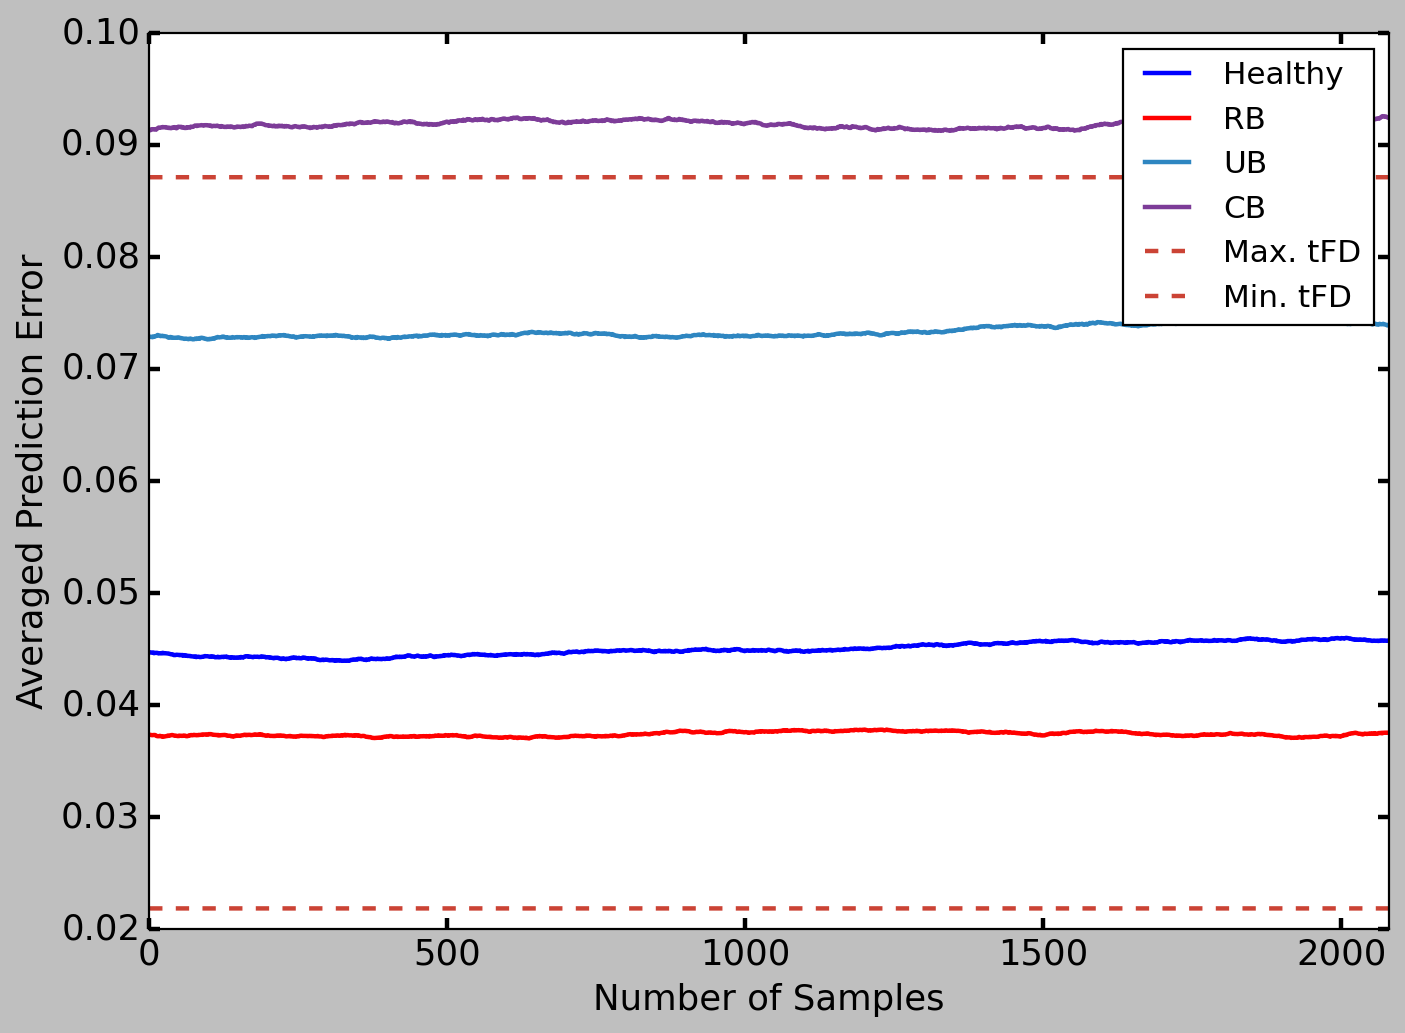

In [ ]:
plt.figure(figsize=(10,7))
plt.style.use('classic')
plt.rcParams['font.size'] = '16'
#plt.plot(diferencia, label='diferencia')
#plt.plot(datatest1["target"], label='target')
p=len(result[result.target==1]['error'].rolling(ws).mean()[ws-1:].values)

#plt.plot(error_train, color="lime", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Train')


plt.plot(result[result.target==1]['error'].rolling(ws).mean()[ws-1:].values, color="blue", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Healthy')
plt.plot(result[result.target==2]['error'].rolling(ws).mean()[ws-1:].values, color="red", marker=".", markersize=1, linestyle='solid',linewidth=2,label='RB')
plt.plot(result[result.target==3]['error'].rolling(ws).mean()[ws-1:].values, color=[i/255 for i in (46, 134, 193)], marker=".", markersize=1, linestyle='solid',linewidth=2,label='UB')
plt.plot(result[result.target==4]['error'].rolling(ws).mean()[ws-1:].values, color=[i/255 for i in (125, 60, 152 )], marker=".", markersize=1, linestyle='solid',linewidth=2,label='CB')

plt.xlabel('Number of Samples', fontsize=16)
plt.ylabel('Averaged Prediction Error', fontsize=16)
plt.plot([mean+2*std]*p, color=[i/255 for i in (203, 67, 53 )], linestyle='--',linewidth=2,label='Max. tFD')
plt.plot([mean-2*std]*p, color=[i/255 for i in (203, 67, 53 )], linestyle='--',linewidth=2,label='Min. tFD')
#plt.plot([np.max(error_train)]*p, color="skyblue", linestyle='--',linewidth=2,label='Lower threshold')
plt.xlim(right=2080)
plt.tick_params(which='both', width=2, length=5)
#plt.gcf().autofmt_xdate()
#plt.tight_layout()
plt.legend(frameon=True,fontsize=14)
plt.savefig("J3RESULTS.pdf",bbox_inches='tight')

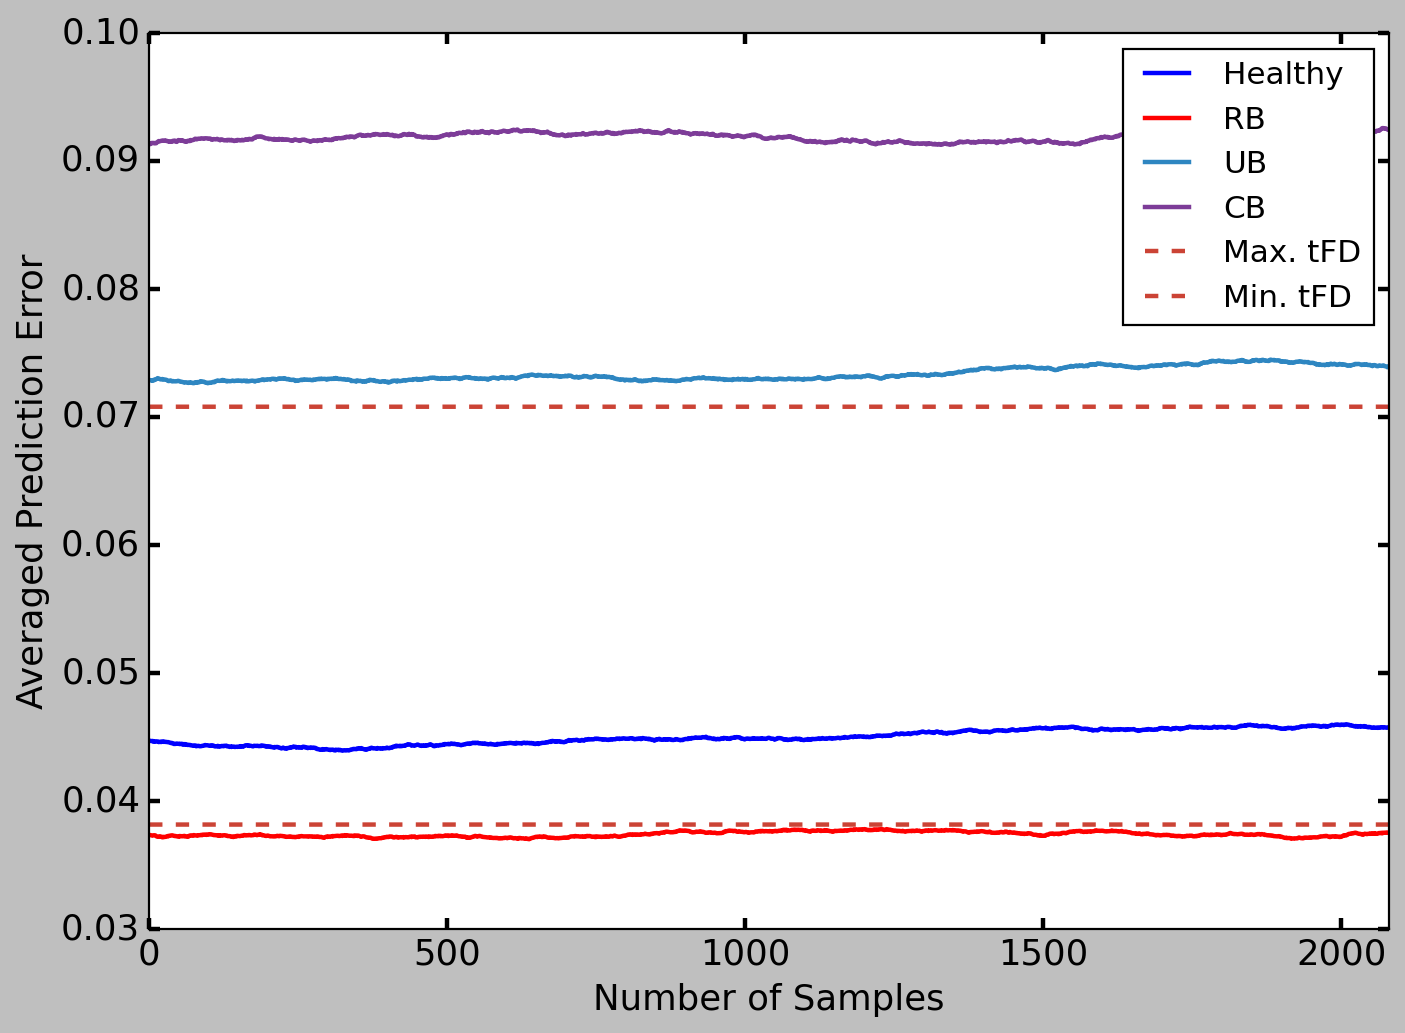

In [ ]:
plt.figure(figsize=(10,7))
plt.style.use('classic')
plt.rcParams['font.size'] = '16'
#plt.plot(diferencia, label='diferencia')
#plt.plot(datatest1["target"], label='target')
p=len(result[result.target==1]['error'].rolling(ws).mean()[ws-1:].values)

#plt.plot(error_train, color="lime", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Train')


plt.plot(result[result.target==1]['error'].rolling(ws).mean()[ws-1:].values, color="blue", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Healthy')
plt.plot(result[result.target==2]['error'].rolling(ws).mean()[ws-1:].values, color="red", marker=".", markersize=1, linestyle='solid',linewidth=2,label='RB')
plt.plot(result[result.target==3]['error'].rolling(ws).mean()[ws-1:].values, color=[i/255 for i in (46, 134, 193)], marker=".", markersize=1, linestyle='solid',linewidth=2,label='UB')
plt.plot(result[result.target==4]['error'].rolling(ws).mean()[ws-1:].values, color=[i/255 for i in (125, 60, 152 )], marker=".", markersize=1, linestyle='solid',linewidth=2,label='CB')

plt.xlabel('Number of Samples', fontsize=16)
plt.ylabel('Averaged Prediction Error', fontsize=16)
plt.plot([mean+std]*p, color=[i/255 for i in (203, 67, 53 )], linestyle='--',linewidth=2,label='Max. tFD')
plt.plot([mean-std]*p, color=[i/255 for i in (203, 67, 53 )], linestyle='--',linewidth=2,label='Min. tFD')
#plt.plot([np.max(error_train)]*p, color="skyblue", linestyle='--',linewidth=2,label='Lower threshold')
plt.xlim(right=2080)
plt.tick_params(which='both', width=2, length=5)
#plt.gcf().autofmt_xdate()
#plt.tight_layout()
plt.legend(frameon=True,fontsize=14)
plt.savefig("J3RESULTS.pdf",bbox_inches='tight')